# Zadanie nr 1.2.5 - Testowanie różnych funkcji aktywacji
## Metody Inteligencji Obliczeniowej w Analizie Danych
### Paweł Koźmiński, 298825

Głównym wyzwaniem stojącym przed rozwiązującymi laboratorium nr 1.2.5 jest implementacja innych niż poprzednio funkcji aktywacji w neuronach warstw ukrytych. Do znanej już wcześniej funkcji logistycznej należy dodać funkcje:
- tanh
- ReLU
- liniową.

Należy pamiętać o poprawnym dodaniu pochodnych powyższych funkcji do całokształtu rozwiązania.
Efekt zmian należy przetestować na dwóch zbiorach danych dotyczących klasyfikacji:
- `rings3-regular`
- `rings5-regular`

oraz dwóch zbiorach z zadaniem regresji:
- `steps-large`
- `multimodal-large`.

Działanie poszczególnych funkcji zostało porównane w kontekście czasu trenowania modeli oraz ich skuteczności dla różnych parametrów.


In [28]:
import math
import numpy as np
from scipy.misc import derivative
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, mean_squared_error
import networkx as nx

import logging
logging.getLogger().setLevel(logging.CRITICAL)

def sigmoid(x):
    return 1/(1+np.exp(x))

class Net:
    def __init__(self, n_inputs, hidden_neurons_n, n_outputs, weights, hidden_activation_fun='sigmoid',
                 last_activation_fun='linear', uniform_weights_limits = (-1, 1)):
        """
        Constructor of object Net takes many arguments required for building a model:
        n_inputs - number of inputs to the net
        hidden_neurons_n - list of integers pointing the size of hidden layers
        n_outputs - expected size of output
        weights - a string, one of "He", "Xavier", "Uniform", depending on desired method of drawing the initializing weights.
        The possibility of manually input the weights has been disactivated.
        hidden_activation_fun - activation function used in hidden layers
        last_activation_fun - activation function used in last layer
        uniform_weights_limits - a tuple, used only if weights = "Uniform", indicating the parameters (lower, upper) of the uniform distribution to draw the weights from.
        
        """
        self.last_activation_fun = last_activation_fun
        if last_activation_fun == 'linear':
            l_a_f = lambda x: x
            l_deriv = lambda x: np.ones(x.shape)
        elif last_activation_fun == 'sigmoid':
            l_a_f = lambda x: 1/(1+np.exp(-x))
            l_deriv = lambda x: np.exp(-x)/((np.exp(-x)+1)**2)
        elif last_activation_fun == 'softmax':
            def l_a_f(x):
                exp_x = np.exp(x)
                if exp_x.ndim > 1:
                    exp_sum = np.sum(exp_x, axis=1)[:, np.newaxis]
                else:
                    exp_sum = np.sum(exp_x)
                return exp_x/exp_sum
            l_deriv = None #other handling
        elif last_activation_fun == 'tanh':
            l_a_f = np.tanh
            l_deriv = lambda x: 1/np.cosh(x)**2
        elif last_activation_fun == 'relu':
            l_a_f = lambda x: np.maximum(x, 0)
            l_deriv = lambda x: np.where(x>0, 1, 0)
        else:
            raise AttributeError(f'Activation function {last_activation_fun} has not been implemented yet')
        if hidden_activation_fun == 'linear':
            h_a_f = lambda x: x
            h_deriv = lambda x: np.ones(x.shape)
        elif hidden_activation_fun == 'sigmoid':
            h_a_f = lambda x: 1/(1+np.exp(-x))
            h_deriv = lambda x: np.exp(-x)/((np.exp(-x)+1)**2)
        elif hidden_activation_fun == 'tanh':
            h_a_f = np.tanh
            h_deriv = lambda x: 1/np.cosh(x)**2
        elif hidden_activation_fun == 'relu':
            h_a_f = lambda x: x * (x > 0)
            h_deriv = lambda x: (x>0).astype('float128')
        else:
            raise AttributeError(f'Activation function {hidden_activation_fun} has not been implemented yet')
            
        Layers = [self.Layer(n_inputs, hidden_neurons_n[0], weights, None, h_a_f, h_deriv, uniform_weights_limits)]
        Layers = Layers + [self.Layer(hidden_neurons_n[j], hidden_neurons_n[j+1], weights, None, h_a_f, h_deriv,
                                       uniform_weights_limits) for j in range(len(hidden_neurons_n)-1)]
        Layers = Layers + [self.Layer(hidden_neurons_n[-1], n_outputs, weights, None, l_a_f, l_deriv, uniform_weights_limits)]
        self.layers_list = Layers
        self.layers_size = [n_inputs] + hidden_neurons_n + [n_outputs]
        
    def train(self, data, optimisation = None, optimisation_param = 0.2, learning_rate=0.005, epochs=5,
              batch_size = 1, plot = True, verbose = True):
        """
        data - numpy.array of numpy arrays of shape (2, ...) where first element is the input and the second is output.
        Due to the structure of numpy array, both inputs and labels need to be of the same length. Please fill the shorter one with any values just to align it.
        Only first <n_inputs> or <n_outputs> will be taken into consideration.
        optimisation - one of None, 'momentum' or 'RMSProp' - method of optimisation method
        optimisation_param - used when optimisation is not None - parameter of chosen method
        batch_size - number of observations presented to the net in one iteration. When batch_size>len(data) it is minimised to len(data)
        plot - should the net be visualized during training?
        """
        if not (optimisation is None or optimisation == "momentum" or optimisation == "rmsprop"):
            raise AttributeError(f"Invalid value of optimisation type: {optimisation}")
        #create net graph
        if plot:
            G = nx.Graph()
            G.add_nodes_from(range(sum(self.layers_size)))
            #add edges to graph
            pom = 0
            pom2 = 0
            for k in range(len(self.layers_size)-1):
                pom += self.layers_size[k]
                for i in range(pom2, pom):
                    for j in range(pom, pom+self.layers_size[k+1]):
                        G.add_edge(i, j)
                pom2 += self.layers_size[k]
        current_mse = [0]*epochs
        responses = data[:,1,0:self.layers_size[-1]]
        #let's train:
        for k in range(epochs):
            if verbose: print(f"Epoch {k+1} out of {epochs} ({round((k)/epochs*100)}%)")
            
            for n_batch in range(0, len(data), batch_size):
                cur_data = data[n_batch:(min((n_batch+batch_size), len(data))),:,:] #slicing the data to batch
                changing_x = cur_data[:,0, 0:self.layers_size[0]] #independent values
                expected_y = cur_data[:,1,0:self.layers_size[-1]] #target
                
                for i in range(0, len(self.layers_list)): #feed forward
                    changing_x = self.layers_list[i].go(changing_x)
                    
                for i in range(len(self.layers_list)-1, -1, -1): #back propagation
                    if i == len(self.layers_list)-1: #the last layer is a little bit different
                        if self.last_activation_fun == 'softmax':
                            # in case of softmax - a vector function - its not that easy...
                            # the jacobian must be calculated for every observation in a batch
                            # and it's structure is (I-p)*p.reshape(-1,1) where p is a vector of probabilites.
                            # vector operations - with 3d-matrix multiplication but without slower loop (45% time reduction)
                            tmp_errors = (changing_x-expected_y).reshape(expected_y.shape[0], 1, expected_y.shape[1])
                            identity3d = np.repeat(np.identity(expected_y.shape[1])[np.newaxis, :, :], expected_y.shape[0], 0)
                            d = changing_x.reshape(changing_x.shape[0], 1, changing_x.shape[1])
                            jacobians =  (identity3d-d) * d.reshape(d.shape[0],-1, 1)
                            self.layers_list[i].err = np.squeeze(np.matmul(tmp_errors, jacobians))
                        else:#if self.last_activation_fun == 'linear' or self.last_activation_fun == 'sigmoid':
                            self.layers_list[i].err = (changing_x-expected_y)\
                            *self.layers_list[i].derivative_fun(self.layers_list[i].activation_argument)    
                    if i>0: #other layers
                        self.layers_list[i-1].err = np.dot(self.layers_list[i].err, np.transpose(self.layers_list[i].weights))\
                        *self.layers_list[i-1].derivative_fun(self.layers_list[i-1].activation_argument)
                # weights correction
                if optimisation is None: 
                    for i in range(len(self.layers_list)-1, -1, -1):
                        weights_delta = -1 * learning_rate * np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err)/len(cur_data) #mean of gradients
                        bias_delta = (-1 * learning_rate * self.layers_list[i].err).reshape(len(cur_data), self.layers_list[i].neurons)
                        bias_delta = np.mean(bias_delta, axis = 0)
                        self.layers_list[i].weights += weights_delta
                        self.layers_list[i].bias += bias_delta.reshape(-1,)
                elif optimisation == "momentum":
                    for i in range(len(self.layers_list)-1, -1, -1):
                        weights_delta = -1 * np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err)/len(cur_data) #mean of gradients
                        bias_delta = (-1 * self.layers_list[i].err).reshape(len(cur_data), self.layers_list[i].neurons)
                        bias_delta = np.mean(bias_delta, axis = 0)
                        self.layers_list[i].optimisation_weights *= optimisation_param
                        self.layers_list[i].optimisation_weights += weights_delta
                        self.layers_list[i].optimisation_bias *= optimisation_param
                        self.layers_list[i].optimisation_bias += bias_delta.reshape(-1,)
                        self.layers_list[i].weights += learning_rate * self.layers_list[i].optimisation_weights
                        self.layers_list[i].bias += learning_rate * self.layers_list[i].optimisation_bias
                else: #optimisation == "rmsprop"
                    for i in range(len(self.layers_list)-1, -1, -1):
                        g_weights = np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err)/len(cur_data) #mean of gradients
                        g_bias = self.layers_list[i].err.reshape(len(cur_data), self.layers_list[i].neurons)
                        g_bias = np.mean(g_bias, axis = 0).reshape(-1,)
                        self.layers_list[i].optimisation_weights *= optimisation_param
                        self.layers_list[i].optimisation_weights += (1-optimisation_param) * np.power(g_weights, 2)
                        self.layers_list[i].optimisation_bias *= optimisation_param
                        self.layers_list[i].optimisation_bias += (1-optimisation_param) * np.power(g_bias, 2)
                        self.layers_list[i].weights -= learning_rate * (g_weights/(np.sqrt(self.layers_list[i].optimisation_weights) + 1e-5))
                        self.layers_list[i].bias -= learning_rate * (g_bias/(np.sqrt(self.layers_list[i].optimisation_bias)+1e-5))
                        
            #add weights to the graph plot
            if plot and k % max(1, (round(epochs/15))) == 0:
                edge_labels = dict()
                for z in range(0, len(self.layers_size)-1):
                    edge_labels = {**edge_labels, **{(i, j): round(self.layers_list[z].weights[i-(0 if z==0 else np.cumsum(self.layers_size)[z-1]),j-np.cumsum(self.layers_size)[z]], 2)
                                    for i in range(0 if z==0 else np.cumsum(self.layers_size)[z-1],np.cumsum(self.layers_size)[z])
                                    for j in range(np.cumsum(self.layers_size)[z],np.cumsum(self.layers_size)[z+1])}}
                plt.figure(figsize = (10, 6))
                # nodes position:
                pos = {j: (p, 1/(self.layers_size[p]+1)*(j-(0 if p==0 else np.cumsum(self.layers_size)[p-1])+1)) 
                                    for p in range(len(self.layers_size))
                                    for j in range(0 if p==0 else np.cumsum(self.layers_size)[p-1], np.cumsum(self.layers_size)[p])}
                nx.draw_networkx(G, pos, alpha = 0.9, with_labels=False)
                #Displaying edge labels on different positions:
                edge_labels_list = list(edge_labels.items())
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[::4]), label_pos = 0.2, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[1::4]), label_pos = 0.4, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[2::4]), label_pos = 0.6, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[3::4]), label_pos = 0.8, font_color = 'red')
                plt.show()
            
            cur_epoch_predictions = data[:,0,0:self.layers_size[0]] 
            for i in range(0, len(self.layers_list)): #feed forward
                cur_epoch_predictions = self.layers_list[i].go(cur_epoch_predictions)
            if self.last_activation_fun == 'softmax': #classification
                idxs = np.where(responses == 1)
                current_mse[k] = mean_squared_error(responses[idxs], cur_epoch_predictions[idxs])
            else: 
                current_mse[k] = mean_squared_error(responses, cur_epoch_predictions)
        plt.plot(current_mse)
        plt.xlabel('Epoch')
        plt.ylabel('MSE loss')
        plt.show()
        #finally, return the predicted output:
        changing_x = data[:,0,0:self.layers_size[0]] 
        for i in range(0, len(self.layers_list)): #feed forward
                changing_x = self.layers_list[i].go(changing_x)
        return changing_x # note that when used for classification - only probabilities are returned
    def predict(self, x):
        """
        x - numpy array of inputs to be predicted by (assumably already trained) Net
        """
        changing_x = x[:, 0:self.layers_size[0]]
        for i in range(0, len(self.layers_list)):
                changing_x = self.layers_list[i].go(changing_x)
        return changing_x
    
    class Layer:
        def __init__(self, n_inputs, neurons, weights, bias, activation_fun, derivative_fun, uniform_weights_limits=(-1, 1)):
            """
            The constructor of Layer class takes as arguments:
            n_inputs - number of inputs into a layer,
            neurons - number of layers in a layer,
            weights - weights of inputs of a layer - highly recommended for weights to be of class numpy.array or "He"/"Xavier"/"Uniform"
            bias - values of bias - preferably numpy.array as well,
            activation - activation function (possibly lambda function) 
            """
            self.neurons = neurons
            self.n_inputs = n_inputs
            self.activation_fun = activation_fun
            if weights == "He":
                weights = np.random.normal(scale=np.sqrt(2/n_inputs), size = (n_inputs, neurons))
                bias = np.random.normal(scale=np.sqrt(2/n_inputs), size = (neurons,))
            elif weights == "Xavier":
                weights = np.random.uniform(-np.sqrt(6/(neurons+n_inputs)), np.sqrt(6/(neurons+n_inputs)), size = (n_inputs, neurons))
                bias = np.random.uniform(-np.sqrt(6/(neurons+n_inputs)), np.sqrt(6/(neurons+n_inputs)), size = (neurons,))
            elif weights == "Uniform":
                weights = np.random.uniform(uniform_weights_limits[0], uniform_weights_limits[1], (n_inputs, neurons))
                bias = np.random.uniform(uniform_weights_limits[0], uniform_weights_limits[1], (neurons,))
            if len(weights.shape) == 1:
                weights = weights.reshape(1, -1)
            if weights.shape == (n_inputs, neurons):
                self.weights = weights
            else:
                raise AttributeError("The dimensions of weights are not aligned")
            if len(weights.shape) == 1:
                if len(bias) == len(weights):
                    self.bias = bias
            elif len(bias) == weights.shape[1]:
                self.bias = bias
            else:
                raise AttributeError("Incorrect length of bias")
            
            self.derivative_fun = derivative_fun
            self.activation_argument = None
            self.err = None
            self.out_value = None
            self.input_values = None
            self.optimisation_weights = np.zeros((self.n_inputs, self.neurons))
            self.optimisation_bias = np.zeros((self.neurons,))
        def go(self, x_input):
            """
            x_input - numpy.array containing data used in a layer.
            """
            if x_input.shape[1] != self.n_inputs:
                raise AttributeError("The dimensions of input are incorrect for this layer")
            self.input_values = x_input
            self.activation_argument = np.dot(x_input, self.weights) + self.bias
            self.out_value = self.activation_fun(self.activation_argument)
            return self.out_value

Zdefiniujmy potrzebne w poniższym sprawozdaniu funkcje. Zauważmy, że o ile nie będzie spomniane, sieci będą trenowane z przyspieszeniem `momentum` z parametrem 0.99, współczynnikiem uczenia równym 0.005, metodą inicjalizacji wag Xaviera oraz podejściem batchowym z 32 obserwacjami w jednym z nich.

In [65]:
def plot_fit(x, y, c_pred, c_ref, legend, hidden_layers):
    if c_ref is not None:
        if y is not None:
            plt.scatter(x, y, c = c_pred)
            plt.title(f'{len(hidden_layers)} hidden layer(s) with {hidden_layers} neurons. Accuracy: {round(accuracy_score(c_ref, c_pred), 2)}')
        else:
            plt.scatter(x, c_pred, label = 'Predicted')
            plt.scatter(x, c_ref, label = 'Original')
            plt.title(f'{len(hidden_layers)} hidden layer(s) with {hidden_layers} neurons. MSE: {round(mean_squared_error(c_ref, c_pred), 2)}')
        plt.legend(title = f'{legend} data')
    else:
        if y is not None:
            plt.scatter(x, y, c = c_pred)
        else:
            plt.scatter(x, c_pred)
        plt.title('Original training data')
    plt.show()

def train_plot_wrap(train_data, train_data_labels, test_data, test_data_labels, hidden_layers, n_outputs,
                    hidden_activation_fun, last_activation_fun, weights='Xavier', n_inputs=2, optimisation='momentum',
                    optimisation_param = 0.99, learning_rate=0.005, epochs = 1000, btch = 32, plot = False,
                    classification = True):
    #Just for this exercise
    nn = Net(n_inputs = n_inputs, hidden_neurons_n=hidden_layers, n_outputs=n_outputs, weights = weights, hidden_activation_fun=hidden_activation_fun,
             last_activation_fun = last_activation_fun)
    y_pred = nn.train(train_data, optimisation = optimisation, optimisation_param=optimisation_param,
                      learning_rate=learning_rate, epochs = epochs, batch_size = btch, plot = plot, verbose = False)
    if classification:
        plot_fit(train_data[:,0, 0], train_data[:,0, 1], np.argmax(y_pred, axis = 1), train_data_labels,
                'Training', hidden_layers)
        y_test_pred = nn.predict(test_data[:,0])
        plot_fit(test_data[:,0,0], test_data[:,0, 1], np.argmax(y_test_pred, axis = 1), test_data_labels,
            'Testing', hidden_layers)
    else:
        plot_fit(train_data[:,0, 0], None, y_pred, train_data_labels,
                'Training', hidden_layers)
        y_test_pred = nn.predict(test_data[:,0])
        plot_fit(test_data[:,0,0], None, y_test_pred, test_data_labels,
            'Testing', hidden_layers)

# 1. zbiór danych - `rings3-regular`
Klasyfikacja - 3 etykiety do dopasowania - funkcja aktywacji `softmax` na wyjściu.

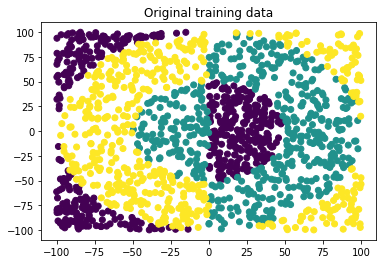

In [29]:
train_df = pd.read_csv('../dane/mio1/classification/rings3-regular-training.csv', dtype='float128').to_numpy()
test_df = pd.read_csv('../dane/mio1/classification/rings3-regular-test.csv', dtype='float128').to_numpy()

train_labels = np.zeros((len(train_df), 3))

for i, j in enumerate(train_df[:,2]):
    train_labels[i, int(j)] = 1
    
train_data_rings = np.array([
    np.array([[x_i, y_i, 0], [c_1, c_2, c_3]])
    for x_i, y_i, c_1, c_2, c_3 in zip(
        train_df[:,0],
        train_df[:,1],
        train_labels[:,0],
        train_labels[:,1],
        train_labels[:,2])])

test_labels = np.zeros((len(test_df), 3))

for i, j in enumerate(test_df[:,2]):
    test_labels[i, int(j)] = 1

test_data_rings = np.array([
    np.array([[x_i, y_i, 0], [l1, l2, l3]])
    for x_i, y_i, l1, l2, l3 in zip(
        test_df[:,0],
        test_df[:,1],
        test_labels[:,0],
        test_labels[:,1],
        test_labels[:,2])])
plot_fit(train_df[:,0], train_df[:,1], c_pred=train_df[:,2], c_ref=None, legend=None, hidden_layers=None)

### a) `ReLU`
- Architektura sieci - warstwy ukryte: [25, 20]
- Epoki: 5000
- Optymalizator: `RMSProp` z parametrem wygaszania 0.99
- współczynnik uczenia: 0.0001

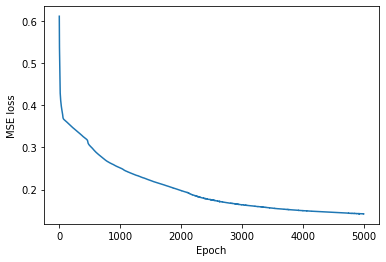

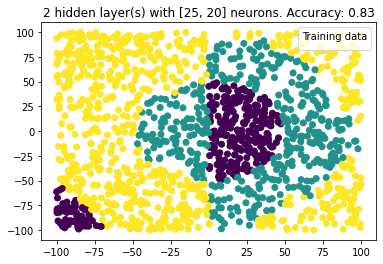

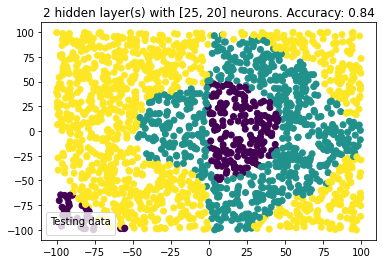

In [93]:
train_plot_wrap(train_data_rings, train_df[:,2], test_data_rings, test_df[:, 2], hidden_layers=[25, 20],
                n_outputs=3, epochs = 5000, hidden_activation_fun='relu', last_activation_fun = 'softmax',
               optimisation='rmsprop', optimisation_param=0.99, learning_rate = 0.0001)

### b) `tanh`
- Architektura sieci - warstwy ukryte: [25, 20]
- Epoki: 5000
- Optymalizator: `RMSProp` z parametrem wygaszania 0.99
- współczynnik uczenia: 0.0001

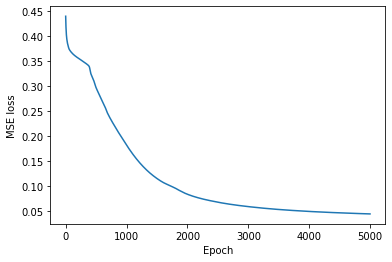

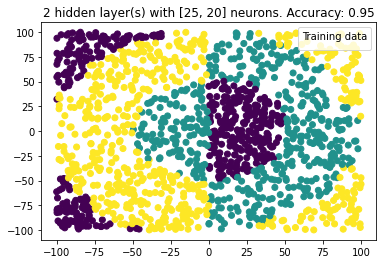

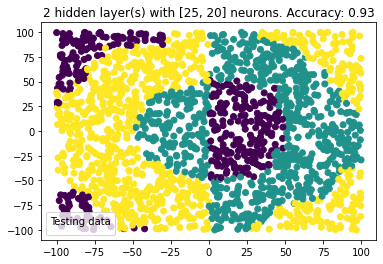

In [96]:
train_plot_wrap(train_data_rings, train_df[:,2], test_data_rings, test_df[:, 2], hidden_layers=[25, 20],
                n_outputs=3, epochs = 5000, hidden_activation_fun='tanh', last_activation_fun = 'softmax',
               learning_rate = 0.0001, optimisation='rmsprop', optimisation_param = 0.99)

### c) `sigmoid`
- Architektura sieci - warstwy ukryte: [25, 20]
- Epoki: 5000
- Optymalizator: `RMSProp` z parametrem wygaszania 0.99
- współczynnik uczenia: 0.0001

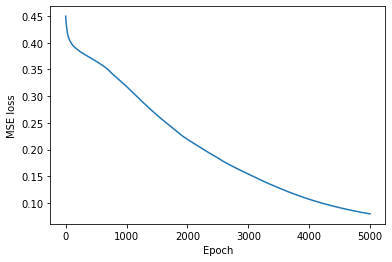

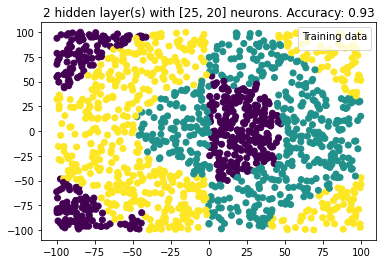

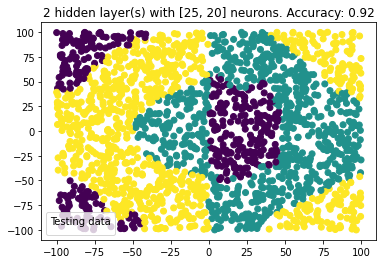

In [59]:
train_plot_wrap(train_data_rings, train_df[:,2], test_data_rings, test_df[:, 2], hidden_layers=[25, 20],
                n_outputs=3, epochs = 5000, hidden_activation_fun='sigmoid', last_activation_fun = 'softmax',
               learning_rate = 0.0001, optimisation = 'rmsprop', optimisation_param = 0.99)

### d) `liniowa`
- Architektura sieci - warstwy ukryte: [15, 15, 8]
- Epoki: 1000
- Optymalizator: Brak
- współczynnik uczenia: 0.002
- rozmiar batcha: 100

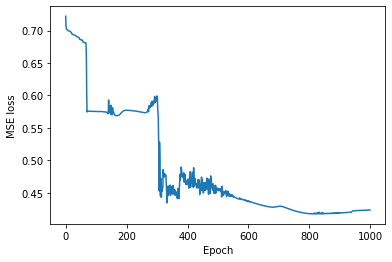

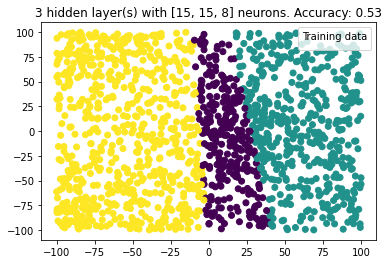

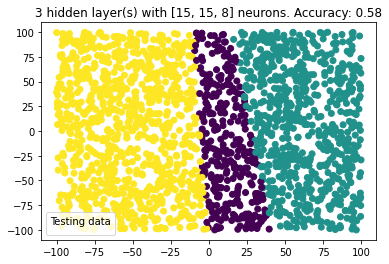

In [36]:
train_plot_wrap(train_data_rings, train_df[:,2], test_data_rings, test_df[:, 2], hidden_layers=[15, 15, 8],
                n_outputs=3, epochs = 1000, hidden_activation_fun='linear', last_activation_fun = 'softmax',
               learning_rate=0.002, optimisation=None, btch = 100)

Spośród powyższych modeli najlepiej spisały się 3 pierwsze - z funkcjami aktywacji `ReLU`, `tanh` oraz `sigmoid`. Wyróżnić należy dwie ostatnie, które uzyskały najwyższy wynik miary `accuracy`. Warto zwrócić uwagę na proces minimalizacji funkcji MSE w kolejnych epokach trenowania modelu z funkcją logistyczną - krzywa przyjmuje bardziej stromy kształt i rozpoczyna się z niższego poziomu.

Zdecydowanie na drugim biegunie znajduje się sieć z liniową funkcji aktywacji. Nie jest to szczególnie dziwne - spoglądając już na rozkład przypisywanych etykiet można było oczekiwać, że poszukiwania wyłącznie w przestrzeni liniowych przekształceń mogą być niewystarczające. Na słaby wynik z pewnością nie wpływa mniejsza liczba epok w procesie trenowania.

# 2. zbiór danych - `rings5-regular`
Klasyfikacja - 5 etykiet do dopasowania - ponownie na wyjściu funkcja `softmax`

In [45]:
train_df2 = pd.read_csv('../dane/mio1/classification/rings5-regular-training.csv', dtype='float128').to_numpy()
test_df2 = pd.read_csv('../dane/mio1/classification/rings5-regular-test.csv', dtype='float128').to_numpy()

train_labels2 = np.zeros((len(train_df2), 5))

for i, j in enumerate(train_df2[:,2]):
    train_labels2[i, int(j)] = 1
    
train_data_rings2 = np.array([
    np.array([[x_i, y_i, 0, 0, 0], [c_1, c_2, c_3, c_4, c_5]])
    for x_i, y_i, c_1, c_2, c_3, c_4, c_5 in zip(
        train_df2[:,0],
        train_df2[:,1],
        train_labels2[:,0],
        train_labels2[:,1],
        train_labels2[:,2],
        train_labels2[:,3],
        train_labels2[:,4])])

test_labels2 = np.zeros((len(test_df2), 5))

for i, j in enumerate(test_df2[:,2]):
    test_labels2[i, int(j)] = 1

test_data_rings2 = np.array([
    np.array([[x_i, y_i, 0, 0, 0], [l1, l2, l3, l4, l5]])
    for x_i, y_i, l1, l2, l3, l4, l5 in zip(
        test_df2[:,0],
        test_df2[:,1],
        test_labels2[:,0],
        test_labels2[:,1],
        test_labels2[:,2],
        test_labels2[:,3],
        test_labels2[:,4])])

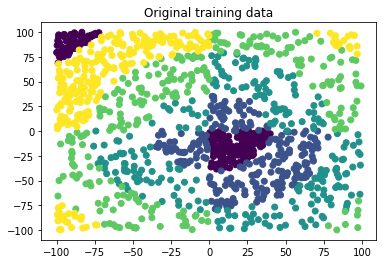

In [46]:
plot_fit(train_df2[:,0], train_df2[:,1], c_pred=train_df2[:,2], c_ref=None, legend=None, hidden_layers=None)

## a) `ReLU`
- Architektura sieci - warstwy ukryte: [15, 10]
- Epoki: 2800
- Optymalizator: `RMSProp` z parametrem wygaszania 0.98
- współczynnik uczenia: 0.0015
- rozmiar batcha: 64

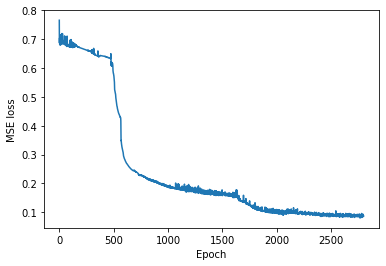

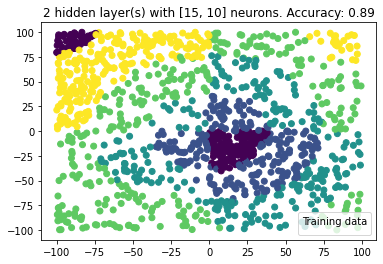

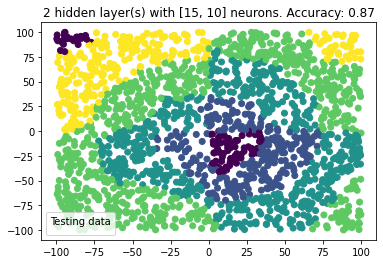

In [60]:
train_plot_wrap(train_data_rings2, train_df2[:,2], test_data_rings2, test_df2[:, 2], hidden_layers=[15, 10],
                n_outputs=5, epochs = 2800, hidden_activation_fun='relu', last_activation_fun = 'softmax',
               learning_rate=0.0015, optimisation='rmsprop', optimisation_param = 0.98, btch = 64)

## b) `tanh`
- Architektura sieci - warstwy ukryte: [15, 10]
- Epoki: 2500
- Optymalizator: `RMSProp` z parametrem wygaszania 0.98
- współczynnik uczenia: 0.001
- rozmiar batcha: 100

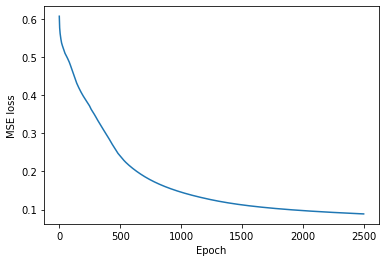

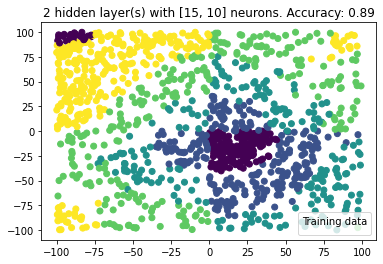

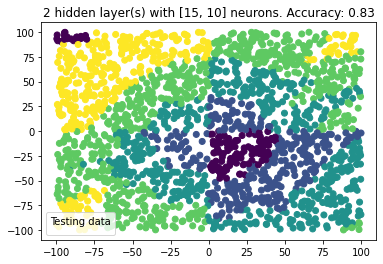

In [49]:
train_plot_wrap(train_data_rings2, train_df2[:,2], test_data_rings2, test_df2[:, 2], hidden_layers=[15, 10],
                n_outputs=5, epochs = 2500, hidden_activation_fun='tanh', last_activation_fun = 'softmax',
               learning_rate=0.001, optimisation='rmsprop', optimisation_param=0.98, btch=100)

## c) `sigmoid`
- Architektura sieci - warstwy ukryte: [15, 10]
- Epoki: 2500
- Optymalizator: `RMSProp` z parametrem wygaszania 0.98
- współczynnik uczenia: 0.001
- rozmiar batcha: 100

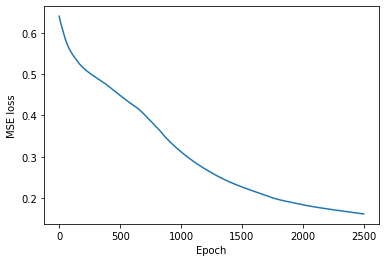

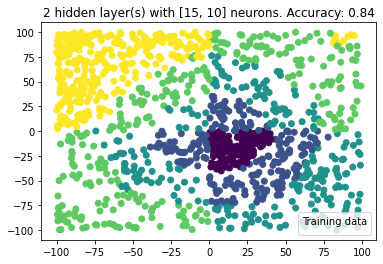

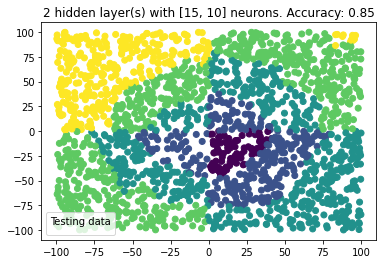

In [51]:
train_plot_wrap(train_data_rings2, train_df2[:,2], test_data_rings2, test_df2[:, 2], hidden_layers=[15, 10],
                n_outputs=5, epochs = 2500, hidden_activation_fun='sigmoid', last_activation_fun = 'softmax',
               learning_rate=0.001, optimisation='rmsprop', optimisation_param=0.98, btch=100)

## d) `liniowa`
- Architektura sieci - warstwy ukryte: [15, 10]
- Epoki: 2500
- Optymalizator: `RMSProp` z parametrem wygaszania 0.98
- współczynnik uczenia: 0.001
- rozmiar batcha: 100

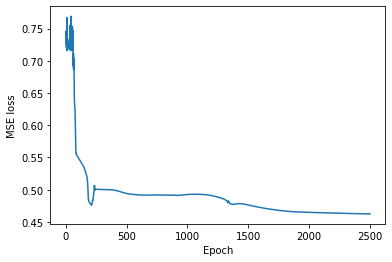

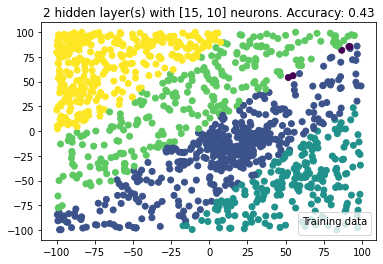

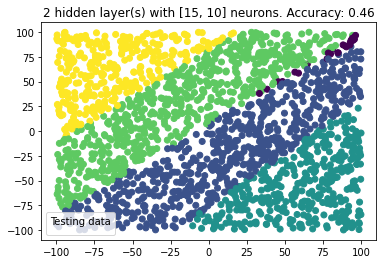

In [52]:
train_plot_wrap(train_data_rings2, train_df2[:,2], test_data_rings2, test_df2[:, 2], hidden_layers=[15, 10],
                n_outputs=5, epochs = 2500, hidden_activation_fun='linear', last_activation_fun = 'softmax',
               learning_rate=0.001, optimisation='rmsprop', optimisation_param=0.98, btch=100)

Ponownie modele można podzielić na dwie kategorie - te, których dopasowanie przebiegło pomyślnie, czyli 3 pierwsze oraz model z liniową funkcją aktywacji, który ponownie nie poradził sobie z postawionym przed nim zadaniem. Tym razem chciałbym zwrócić uwagę na krzywą trenowania modelu z funkcją `ReLU`, która mniej więcej przy 500. epoce notuje bardzo wyraźny spadek funkcji straty.
# 3. zbiór danych - `steps-large`
Regresja, jedna zmienna objaśniająca. Liniowa funkcja wyjściowa aktywacji spowodowana wartościami zmiennej objaśnianej.

In [66]:
train_df3 = pd.read_csv('../dane/mio1/regression/steps-large-training.csv', dtype='float128', index_col=0).to_numpy()
test_df3 = pd.read_csv('../dane/mio1/regression/steps-large-test.csv', dtype='float128', index_col = 0).to_numpy()
    
train_data_steps = np.array([
    np.array([[x_i], [c_1]])
    for x_i, c_1 in zip(
        train_df3[:,0],
        train_df3[:,1])])

test_data_steps = np.array([
    np.array([[x_i], [l1]])
    for x_i, l1 in zip(
        test_df3[:,0],
        test_df3[:,1])])

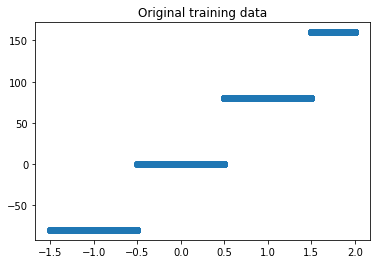

In [67]:
plot_fit(train_df3[:,0], y = None, c_pred=train_df3[:,1],c_ref=None, legend=None, hidden_layers=None)

## a) `ReLU`
- Architektura sieci - warstwy ukryte: [15, 10]
- Epoki: 1500
- Optymalizator: `RMSProp` z parametrem wygaszania 0.99
- współczynnik uczenia: 0.003
- rozmiar batcha: 100

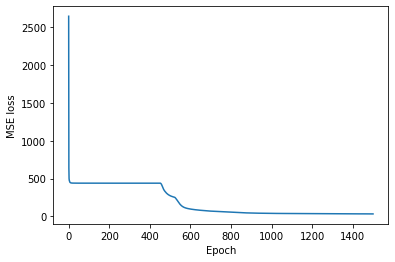

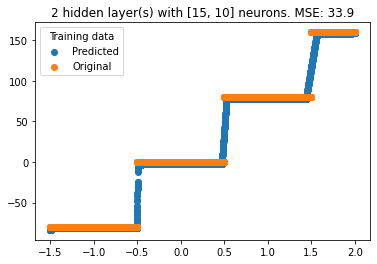

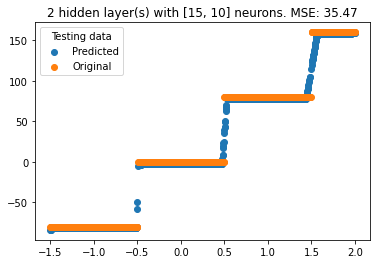

In [83]:
train_plot_wrap(train_data_steps, train_df3[:,1], test_data_steps, test_df3[:, 1], hidden_layers=[15, 10],
                n_inputs=1, n_outputs=1, epochs = 1500, hidden_activation_fun='relu',
                last_activation_fun = 'linear',learning_rate=0.003, classification=False,
                optimisation='rmsprop', optimisation_param = 0.99, btch=100)

## b) `tanh`
- Architektura sieci - warstwy ukryte: [5, 5]
- Epoki: 400
- Optymalizator: Brak
- współczynnik uczenia: 0.003
- rozmiar batcha: 100

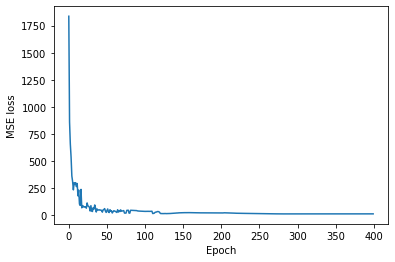

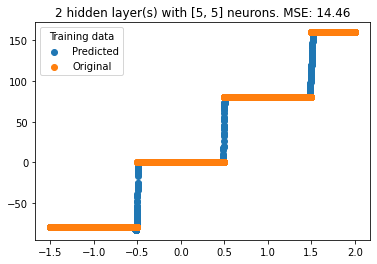

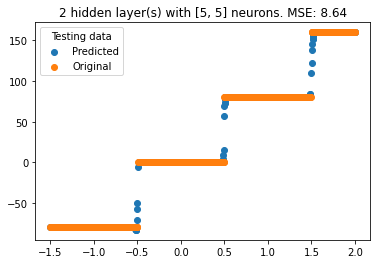

In [70]:
train_plot_wrap(train_data_steps, train_df3[:,1], test_data_steps, test_df3[:, 1], hidden_layers=[5, 5], n_inputs=1,
                n_outputs=1, epochs = 400, hidden_activation_fun='tanh', last_activation_fun = 'linear',
               learning_rate=0.003, classification=False, optimisation = None, btch=100)

## c) `sigmoid`
- Architektura sieci - warstwy ukryte: [5, 5]
- Epoki: 500
- Optymalizator: Brak
- współczynnik uczenia: 0.003
- rozmiar batcha: 100

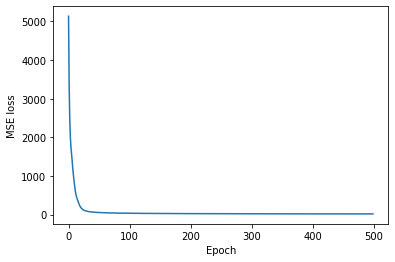

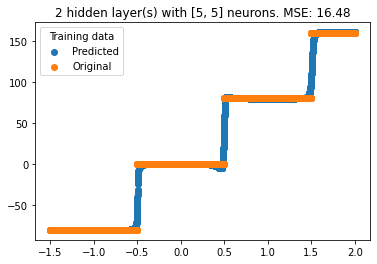

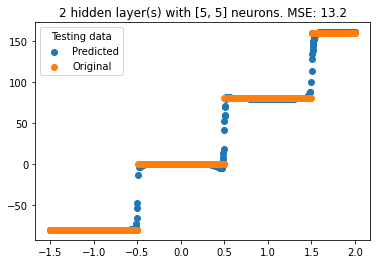

In [75]:
train_plot_wrap(train_data_steps, train_df3[:,1], test_data_steps, test_df3[:, 1], hidden_layers=[5, 5], n_inputs=1,
                n_outputs=1, epochs = 500, hidden_activation_fun='sigmoid', last_activation_fun = 'linear',
               learning_rate=0.003, classification=False, optimisation=None, btch=100)

## d) `liniowa`
- Architektura sieci - warstwy ukryte: [20, 10]
- Epoki: 1000
- Optymalizator: Brak
- współczynnik uczenia: 0.0001
- rozmiar batcha: 100

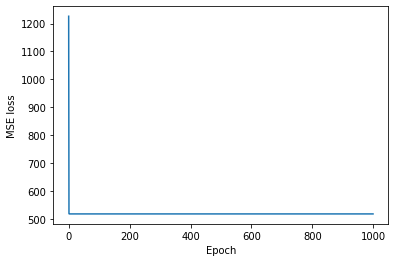

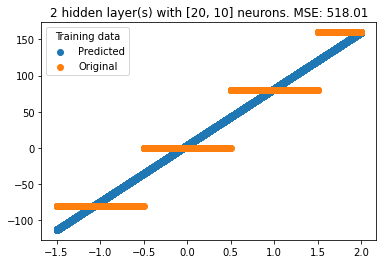

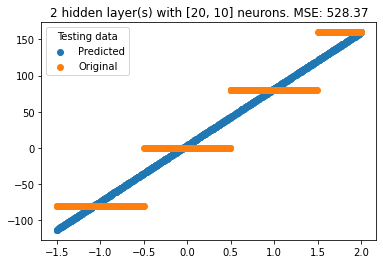

In [84]:
train_plot_wrap(train_data_steps, train_df3[:,1], test_data_steps, test_df3[:, 1], hidden_layers=[20, 10], n_inputs=1,
                n_outputs=1, epochs = 1000, hidden_activation_fun='linear', last_activation_fun = 'linear',
               learning_rate=0.0001, classification=False, optimisation=None, btch=100)

W zadaniu regresji zarówno pod względem skuteczności jak i łatwości dobrania odpowiednich parametrów ponownie przodują modele z `tanh` i `sigmoid`, które juz po kilkudziesięciu epokach osiągają wysokie wyniki. Model z `ReLU`, pomimo bardziej złożonej architektury i dłuższego trenowania, nie dopasował się równie dobrze. Standardowo już funkcja liniowa nie zwraca zadowalających wyników.
# 4. zbiór danych - `multimodal-large`
Regresja, jedna zmienna objaśniająca. Liniowa funkcja wyjściowa aktywacji motywowana wartościami zmiennej objaśnianej.

In [80]:
train_df4 = pd.read_csv('../dane/mio1/regression/multimodal-large-training.csv', dtype='float128', index_col=0).to_numpy()
test_df4 = pd.read_csv('../dane/mio1/regression/multimodal-large-test.csv', dtype='float128', index_col = 0).to_numpy()
    
train_data_multimodal = np.array([
    np.array([[x_i], [c_1]])
    for x_i, c_1 in zip(
        train_df4[:,0],
        train_df4[:,1])])

test_data_multimodal = np.array([
    np.array([[x_i], [l1]])
    for x_i, l1 in zip(
        test_df4[:,0],
        test_df4[:,1])])

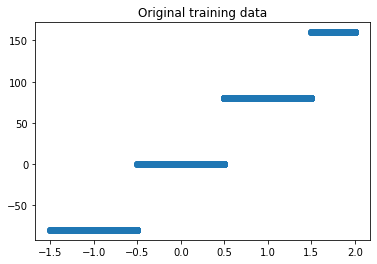

In [81]:
plot_fit(train_df4[:,0], y = None, c_pred=train_df4[:,1],c_ref=None, legend=None, hidden_layers=None)

## a) `ReLU`
- Architektura sieci - warstwy ukryte: [15, 10]
- Epoki: 1500
- Optymalizator: `RMSProp` z współczynnikiem wygaszania 0.98
- współczynnik uczenia: 0.003
- rozmiar batcha: 100

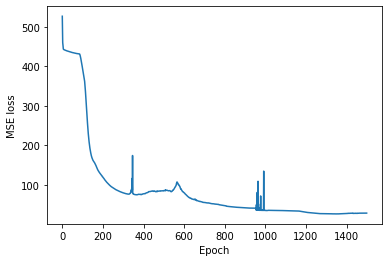

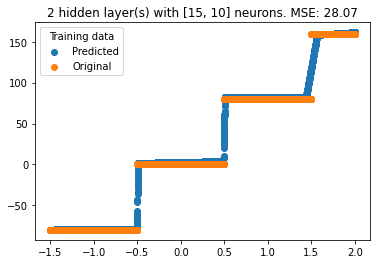

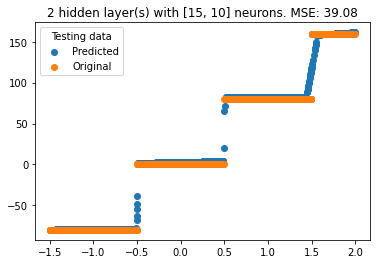

In [92]:
train_plot_wrap(train_data_multimodal, train_df4[:,1], test_data_multimodal, test_df4[:, 1], hidden_layers=[15, 10],
                n_inputs=1, n_outputs=1, epochs = 1500, hidden_activation_fun='relu',
                last_activation_fun = 'linear',learning_rate=0.006, classification=False,
                optimisation='rmsprop', optimisation_param = 0.98, btch=100)

## b) `tanh`
- Architektura sieci - warstwy ukryte: [15, 10]
- Epoki: 1500
- Optymalizator: `RMSProp` z współczynnikiem wygaszania 0.9
- współczynnik uczenia: 0.003
- rozmiar batcha: 100

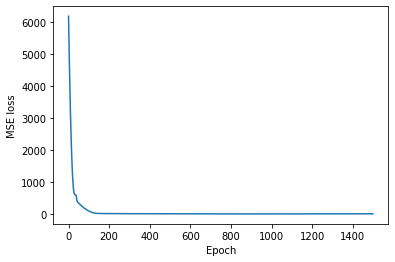

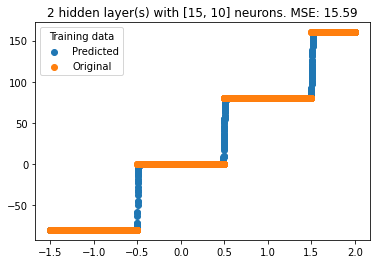

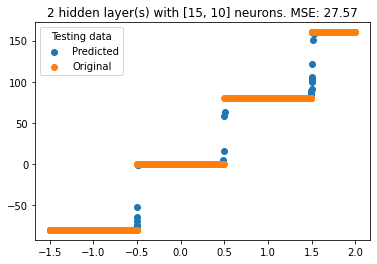

In [86]:
train_plot_wrap(train_data_multimodal, train_df4[:,1], test_data_multimodal, test_df4[:, 1], hidden_layers=[15, 10],
                n_inputs=1, n_outputs=1, epochs = 1500, hidden_activation_fun='tanh',
                last_activation_fun = 'linear',learning_rate=0.003, classification=False,
                optimisation='rmsprop', optimisation_param = 0.9, btch=100)

## c) `sigmoid`
- Architektura sieci - warstwy ukryte: [15, 10]
- Epoki: 1500
- Optymalizator: `RMSProp` z współczynnikiem wygaszania 0.9
- współczynnik uczenia: 0.003
- rozmiar batcha: 100

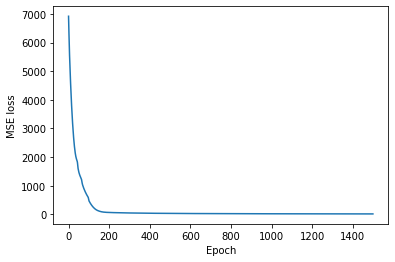

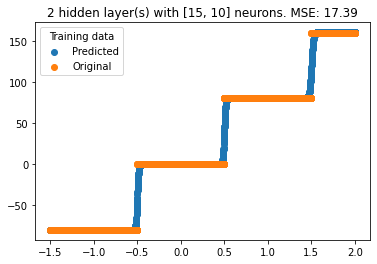

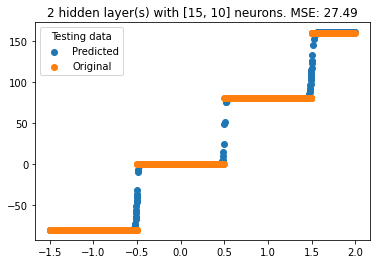

In [87]:
train_plot_wrap(train_data_multimodal, train_df4[:,1], test_data_multimodal, test_df4[:, 1], hidden_layers=[15, 10],
                n_inputs=1, n_outputs=1, epochs = 1500, hidden_activation_fun='sigmoid',
                last_activation_fun = 'linear',learning_rate=0.003, classification=False,
                optimisation='rmsprop', optimisation_param = 0.9, btch=100)

## d) `liniowa`
- Architektura sieci - warstwy ukryte: [15, 10]
- Epoki: 1500
- Optymalizator: `RMSProp` z współczynnikiem wygaszania 0.9
- współczynnik uczenia: 0.003
- rozmiar batcha: 100

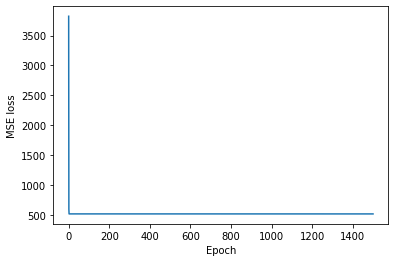

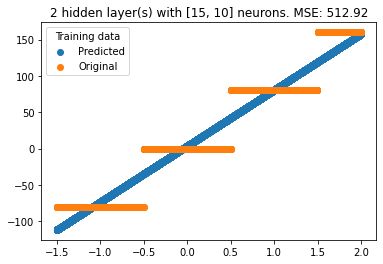

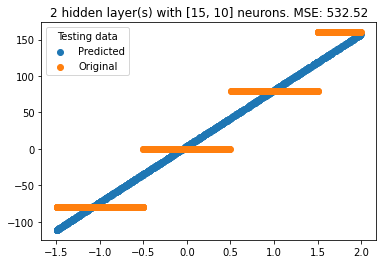

In [88]:
train_plot_wrap(train_data_multimodal, train_df4[:,1], test_data_multimodal, test_df4[:, 1], hidden_layers=[15, 10],
                n_inputs=1, n_outputs=1, epochs = 1500, hidden_activation_fun='linear',
                last_activation_fun = 'linear',learning_rate=0.003, classification=False,
                optimisation='rmsprop', optimisation_param = 0.9, btch=100)

Ze względu na bardzo podobną charakterystykę zbioru jak poprzednio, wnioski są analogiczne.
# Podsumowanie

Implementacja nowych funkcji aktywacji warstw modelu sieci neuronowych przebiegła pomyślnie. Na zbiorach danych dotyczących regresji najlepiej się spisały kolejno modele z `tanh` oraz `sigmoid` jako funkcjami aktywacji neuronów warstw ukrytych. `ReLU` prezentowało się odrobinę gorzej, jednak w zbiorach dotyczących klasyfikacji ta różnica była mniej wyraźna. Wyniki osiągane przez modele z liniową funkcją aktywacji pozwolę sobie opisać następującym obrazkiem:

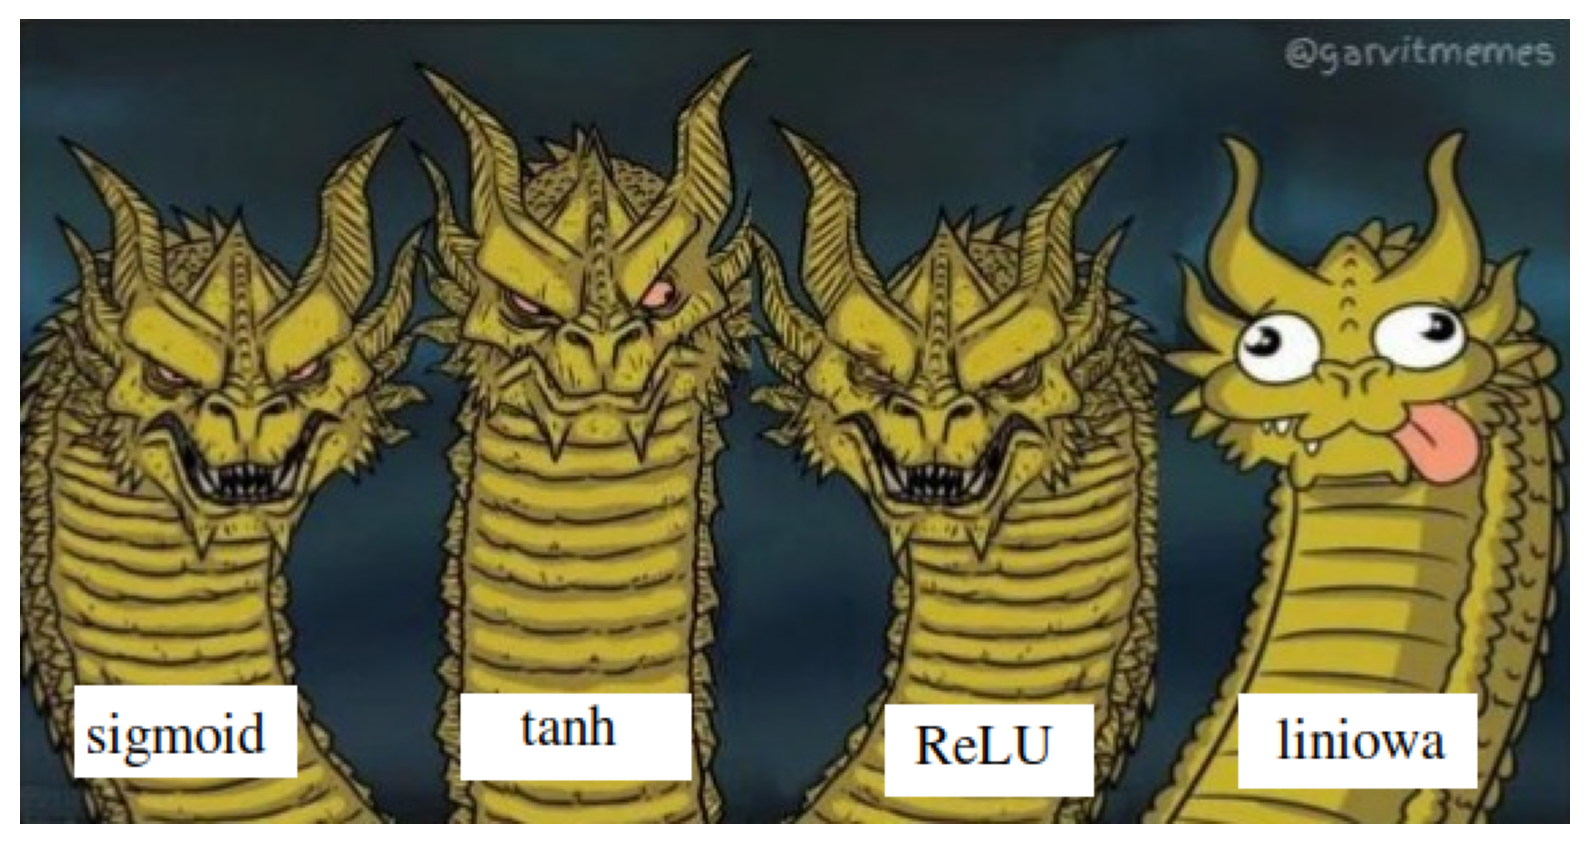

In [113]:
import matplotlib.image as mpimg
try:
    img = mpimg.imread('../../../Pictures/meme.png')
except:
    print("Bez odpalania komórki tu powinien być obrazek.")
plt.figure(figsize=(10, 8), dpi=200)
plt.imshow(img)
plt.axis('off')
plt.show()